## Generate a PSD plot framework for future plots.

In [149]:
#Purisa Jasmine Simmons
#Viren Abhyankar
#February 2020

#Overview: Trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from Scripps buoy that recalibrates every 30 minutes 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [150]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 13)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2  2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3  2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  
0  46.829268  15.853659  15.487805   -37.0  -199.0   517.0  
1   8.902439  -2.439024  12.073171   -33.0  -179.0   533.0  
2 -16.341463   1.463415  14.268293   -46.0  -188.0   528.0  
3  -5.731707  17.439024  21.707317   -64.0  -186.0   522.0  
4 -28.658537   1.219512  21.341463   -91.0  -175.0   493.0  
1538168


## Make a copy of the original motion_df dataframe

In [151]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data included

#print(saved_copy_motion_df)

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [152]:
#Reading data from Scripps_Final_Combined.csv
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Analyze following time period:
#September 9, 2017 -- 18:10 until 18:40

time_e_array = []

time_array = motion_df[['Time']].to_numpy()

#Convert time strings into seconds
start_index = np.where(time_array=='18:10')[0][0]
end_index = np.where(time_array=='18:40')[0][0]
length = end_index-start_index

mins_per_measure = 30/length
sec_per_measure = 60*mins_per_measure

print(sec_per_measure)

#start_time = 18*3600 + 10*60

for i in range(0, length):
    time_e_array.append(sec_per_measure*i)
    
imu_array1 = motion_df.loc[start_index:end_index-1,'IMU A1'].to_numpy()
imu_array2 = motion_df.loc[start_index:end_index-1,'IMU A2'].to_numpy()
imu_array3 = motion_df.loc[start_index:end_index-1,'IMU A3'].to_numpy()

0.21134202183867556


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

Graph of our entire experiment:


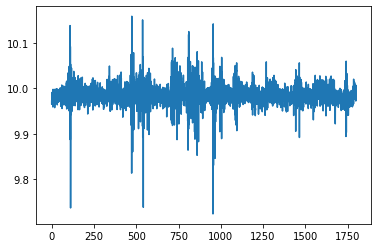

In [153]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity + gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2


##To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)

##To check:
#for t in time_e_array:
#    print(t)


print("Graph of our entire experiment:")

plt.plot(time_e_array, imu2_array)
#plt.ylim(-1,1)
plt.show()

#print("Why are the y-axis values so small?")

## Step 1: Seperate each of the subexperiments into its own acc lists

In [154]:
#for x in time_e_array:
#    print(x)

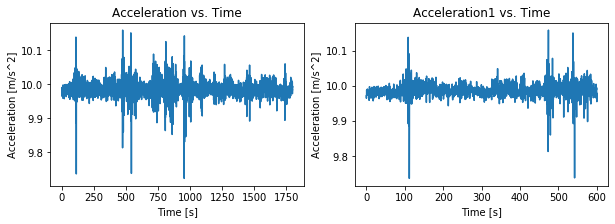

In [155]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []


#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] >= 0 and time_e_array[i] <= 600):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 600 and time_e_array[i] <= 1200):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 1200 and time_e_array[i] <= 1800):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')


ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])


plt.show()
    

## Step 2: Detrend and Double Integrate the data 

In [156]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

#f_s = 5.0 #sampling frequency


### Bandpass filter the data

In [157]:
#First integral of acc to get velocity:
from scipy import integrate

def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t >= low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array


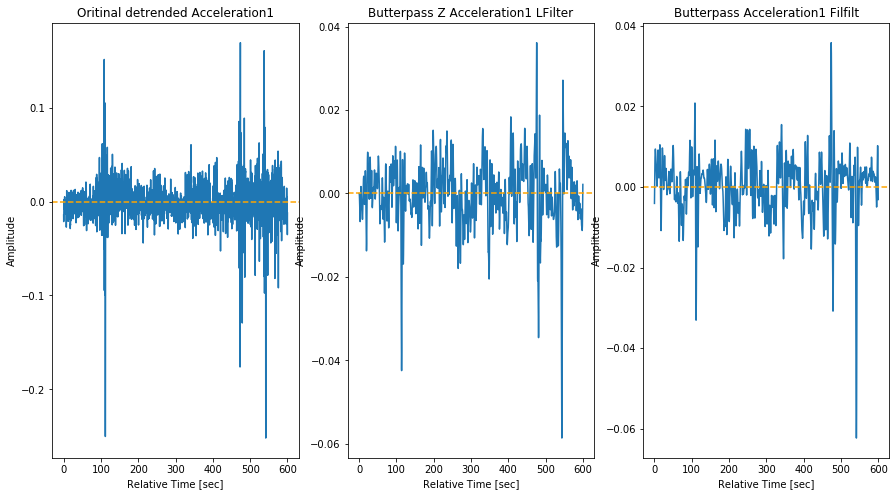

In [158]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
fs = 30
lowcut = 0.0333
highcut = 1.5

##Graphing the bandpass filters:
butter_lfilter = butter_bandpass_lfilter(dacc_array1, lowcut, highcut, fs, order=5)
butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)


new_time = time_array1.copy()

for i in range(len(new_time)):
    if i == 0:
        new_time[i] = 0
    else:
        new_time[i] = new_time[i-1] + 1/fs

        


fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)

ax1.plot(time_array1, dacc_array1)
ax1.set_title('Oritinal detrended Acceleration1')
ax1.set_xlabel('Relative Time [sec]')
ax1.set_ylabel('Amplitude')
ax1.axhline(0, color="orange",ls='--')


ax2.plot(time_array1, butter_lfilter)
ax2.set_title('Butterpass Z Acceleration1 LFilter')
ax2.set_xlabel('Relative Time [sec]')
ax2.set_ylabel('Amplitude')
ax2.axhline(0, color="orange",ls='--')

ax3.plot(time_array1, butter_filtfilt)
ax3.set_title('Butterpass Acceleration1 Filfilt')
ax3.set_xlabel('Relative Time [sec]')
ax3.set_ylabel('Amplitude')
ax3.axhline(0, color="orange",ls='--')


plt.show()

Starting subexperiment 1 analysis:


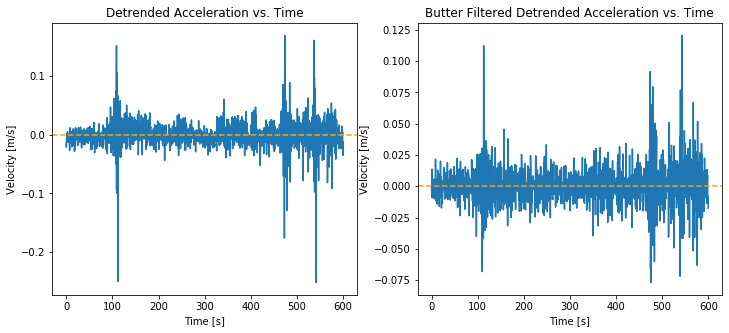

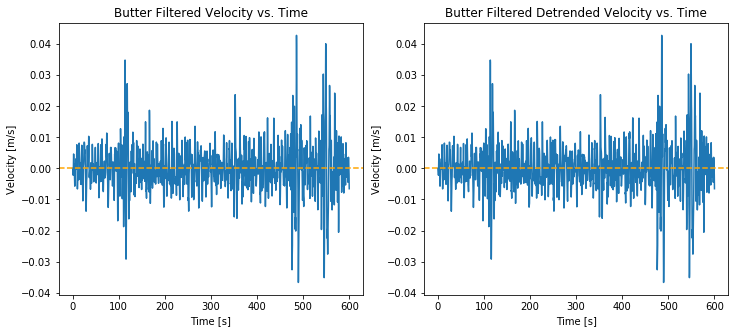

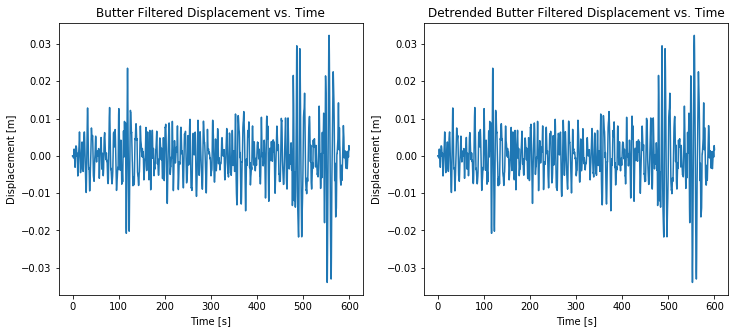

Done.
Starting subexperiment 2 analysis:


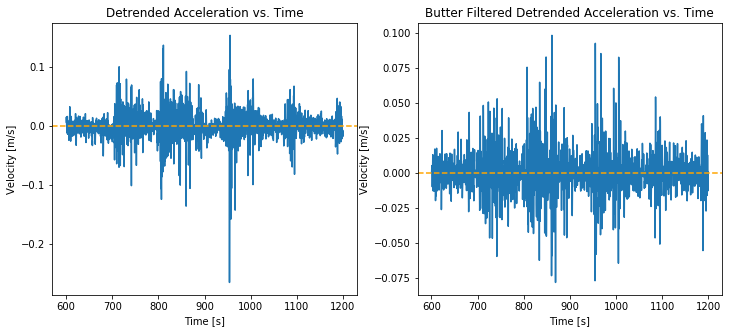

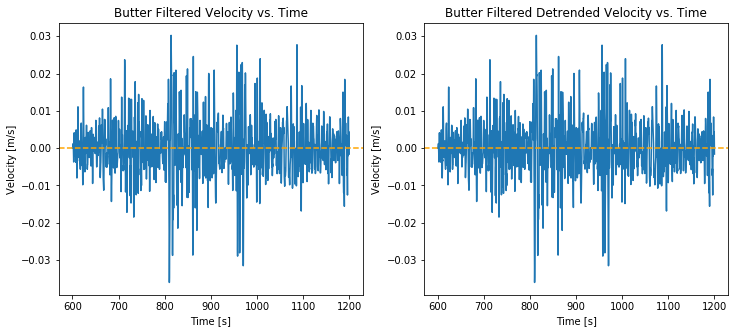

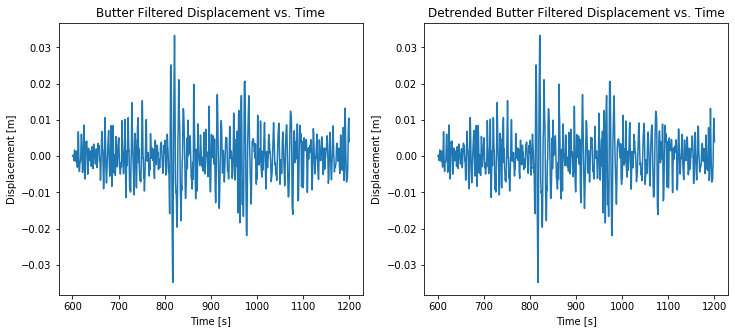

Done.
Starting subexperiment 3 analysis:


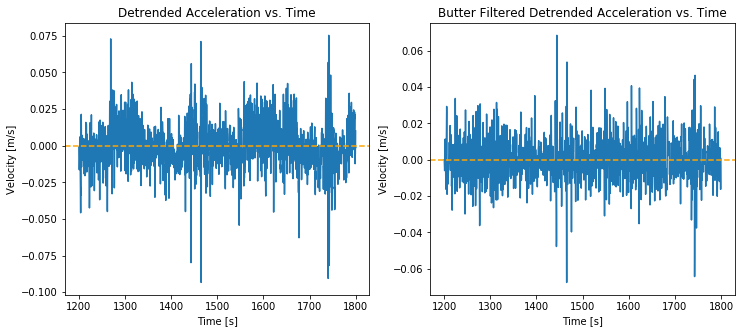

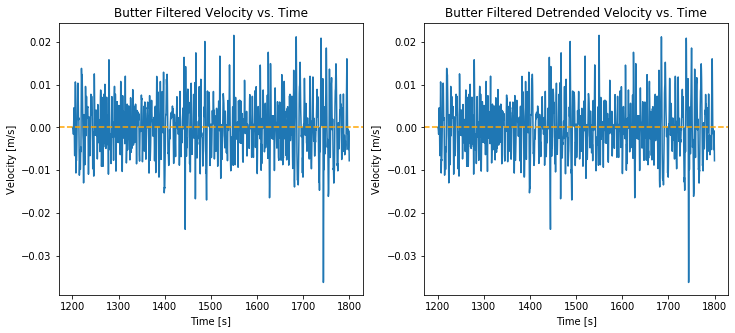

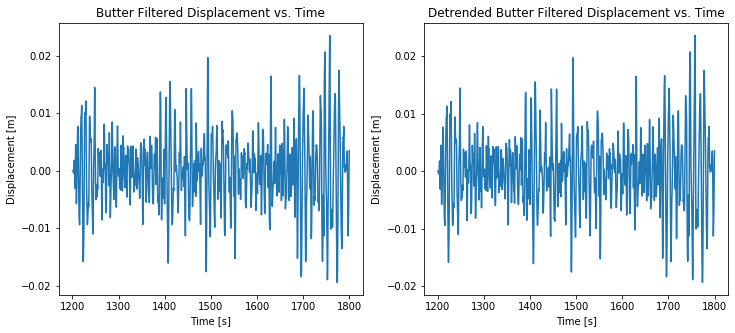

Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.


In [159]:
# Define the sample rate and the Low and High Cutoff frequencies

fs = 5 #redefine the sampling frequency

order=6
lowcut = 0.09
highcut = 1.0

def double_integral_bandpass(time_array, acc_array, dacc_array, lowcut, highcut, fs, order):
    
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)



    f1 = plt.figure(figsize=(12,5))
    ax1 = f1.add_subplot(121)
    ax2 = f1.add_subplot(122)

    f2 = plt.figure(figsize=(12,5))
    ax3 = f2.add_subplot(121)
    ax4 = f2.add_subplot(122)
    
    f3 = plt.figure(figsize=(12,5))
    ax5 = f3.add_subplot(121)
    ax6 = f3.add_subplot(122)

    #Acceleration graphs:
    ax1.plot(time_array, dacc_array)
    ax1.set_title('Detrended Acceleration vs. Time')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Velocity [m/s]')
    ax1.axhline(0, color="orange", ls='--')
    
    ax2.plot(time_array, butter_lfilter)
    ax2.set_title('Butter Filtered Detrended Acceleration vs. Time')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.axhline(0, color="orange", ls='--')
    
    #Velocity graphs:
    ax3.plot(time_array, v_butter_filter_integral)
    ax3.set_title('Butter Filtered Velocity vs. Time')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Velocity [m/s]')
    ax3.axhline(0, color="orange", ls='--')


    ax4.plot(time_array, detrend_v_integral)
    ax4.set_title('Butter Filtered Detrended Velocity vs. Time')
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Velocity [m/s]')
    ax4.axhline(0, color="orange",ls='--')

    
    #Displacement graphs:
    ax5.plot(time_array, disp_butter_filter_integral)
    ax5.set_title('Butter Filtered Displacement vs. Time')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Displacement [m]')               
    
    ax6.plot(time_array, detrend_disp_butter_integral)
    ax6.set_title('Detrended Butter Filtered Displacement vs. Time')
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Displacement [m]')


    plt.show()
    
    return detrend_disp_butter_integral

    
    
##For subexperiment1:
print("Starting subexperiment 1 analysis:")
#Get as close to just the signal (don't want noise)    
new_t1, new_acc1 = calculate_new_range(time_array1, acc_array1, 0, 600)    
new_t1, new_dacc1 = calculate_new_range(time_array1, dacc_array1, 0, 600)
disp_butter_integral1 = double_integral_bandpass(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs, order)
print("Done.")

##For subexperiment2:
print("Starting subexperiment 2 analysis:")
#Get as close to just the signal (don't want noise)    
new_t2, new_acc2 = calculate_new_range(time_array2, acc_array2, 600, 1200)    
new_t2, new_dacc2 = calculate_new_range(time_array2, dacc_array2, 600, 1200)
disp_butter_integral2 = double_integral_bandpass(new_t2, new_acc2, new_dacc2, lowcut, highcut, fs, order)
print("Done.")

## For subexperiment3:
print("Starting subexperiment 3 analysis:")
new_t3, new_acc3 = calculate_new_range(time_array3, acc_array3, 1200, 1800)    
new_t3, new_dacc3 = calculate_new_range(time_array3, dacc_array3, 1200, 1800)
disp_butter_integral3 = double_integral_bandpass(new_t3, new_acc3, new_dacc3, lowcut, highcut, fs, order)


## Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.

print("Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.")

## Peak Picking Algorithm:

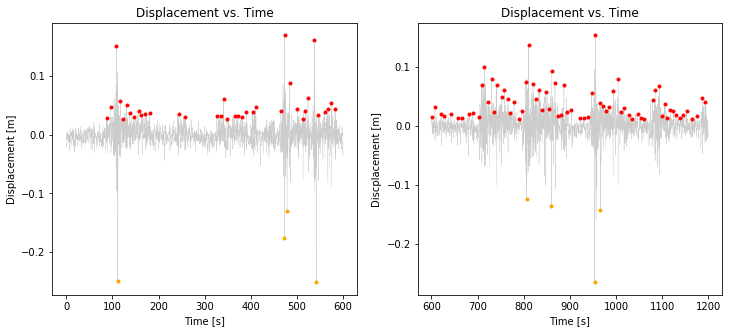

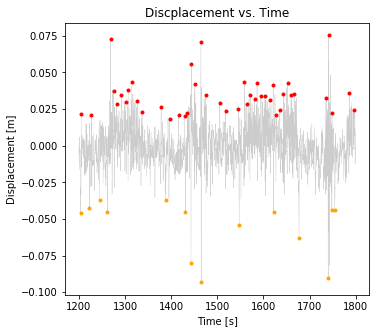

In [160]:
#First, find peaks and valleys of the waveforms:
#(Found that this works better when the data has been detrended.)

#Need to convert to numpy array types: 
new_dacc1 = np.array(new_dacc1)
new_dacc2 = np.array(new_dacc2)
new_dacc3 = np.array(new_dacc3)

new_t1 = np.array(new_t1)
new_t2 = np.array(new_t2)
new_t3 = np.array(new_t3)


indexes0 = peakutils.indexes(new_dacc1, thres=0.02/max(new_dacc1), min_dist=100)
indexes1 = peakutils.indexes(new_dacc2, thres=0.02/max(new_dacc2), min_dist=100)
indexes2 = peakutils.indexes(new_dacc3, thres=0.02/max(new_dacc3), min_dist=100)

col_0t = new_t1 # First column data
col_0a = new_dacc1 # Second column data

col_1t = new_t2 # First column data
col_1a = new_dacc2 # Second column data

col_2t = new_t3 # First column data
col_2a = new_dacc3 # Second column data



#Index1 gets the peaks, while index2 gets the valleys
index_max0 = peakutils.indexes(col_0a, thres=0.66, min_dist=25)
index_min0 = peakutils.indexes(-col_0a, thres=0.66, min_dist=25)

index_max1 = peakutils.indexes(col_1a, thres=0.66, min_dist=25)
index_min1 = peakutils.indexes(-col_1a, thres=0.66, min_dist=25)

index_max2 = peakutils.indexes(col_2a, thres=0.66, min_dist=25)
index_min2 = peakutils.indexes(-col_2a, thres=0.66, min_dist=25)



##Plotting:
f1 = plt.figure(figsize=(12,5))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(12,5))
ax3 = f2.add_subplot(121)


ax1.plot(col_0t,col_0a, lw=0.4, alpha=0.2, color="black" )
ax1.plot(col_0t[index_max0],col_0a[index_max0], marker="o", ls="", ms=3, color="red" )
ax1.plot(col_0t[index_min0],col_0a[index_min0], color ="orange", marker="o", ls="", ms=3 )
ax1.set_title("Displacement vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Displacement [m]')


ax2.plot(col_1t,col_1a, lw=0.4, alpha=0.2, color="black" )
ax2.plot(col_1t[index_max1],col_1a[index_max1], marker="o", ls="", ms=3,  color="red" )
ax2.plot(col_1t[index_min1],col_1a[index_min1], color ="orange", marker="o", ls="", ms=3 )
ax2.set_title("Displacement vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Discplacement [m]")


ax3.plot(col_2t,col_2a, lw=0.4, alpha=0.2, color="black" )
ax3.plot(col_2t[index_max2],col_2a[index_max2], marker="o", ls="", ms=3,  color="red" )
ax3.plot(col_2t[index_min2],col_2a[index_min2], color ="orange", marker="o", ls="", ms=3 )
ax3.set_title("Discplacement vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Displacement [m]")


plt.show()


### Choose the tallest 1/3 of waves to observe, then take the mean of that subset: 

In [161]:
print(len(new_dacc1))

n = int(len(new_dacc1)/3)
print(n)
x0 = new_dacc1
#print (x0[np.argsort(x0)[-n:]])
largest_third = (x0[np.argsort(x0)[-n:]])

print(largest_third)

print(np.mean(largest_third))
wave_height = 2*np.mean(largest_third)
print("Significant wave height calculated as: ", wave_height)

2840
946
[0.00584934 0.00586702 0.00587682 0.0058799  0.00590529 0.00593024
 0.00593709 0.00593754 0.00594662 0.00595323 0.00598222 0.00601433
 0.00601896 0.00602639 0.00602835 0.00602893 0.00602948 0.00604336
 0.00605148 0.00606789 0.00607166 0.00608345 0.00612299 0.00612858
 0.00615185 0.00615493 0.00616644 0.00616785 0.00616881 0.00617148
 0.00618173 0.00619951 0.00622209 0.00624635 0.00624985 0.00628295
 0.00631516 0.0063215  0.00632863 0.00634994 0.00635556 0.00636831
 0.00637293 0.00638304 0.00638527 0.00638609 0.00645271 0.00645661
 0.00646518 0.00647248 0.0064841  0.00652056 0.00652265 0.00657607
 0.0066041  0.00662905 0.00664656 0.00666506 0.00667589 0.00668343
 0.00669703 0.00673503 0.00673644 0.00674836 0.00675984 0.00677231
 0.00677961 0.00679685 0.00681313 0.00681676 0.00682447 0.00685685
 0.00689441 0.00690452 0.00695246 0.00696143 0.00698076 0.00698275
 0.00698891 0.00701496 0.00702407 0.00703391 0.00704104 0.00706585
 0.00707469 0.00707582 0.00709082 0.00709782 0.007128

In [162]:
print(len(index_max0))
n = int(len(index_max0)/3)
print(n)

max_dacc = []
for i in range(0,len(index_max0)):
    max_dacc.append(new_dacc1[index_max0])

max_dacc = np.array(max_dacc)
largest_third = (max_dacc[np.argsort(max_dacc)[-n:]])


print("Significant wave height calculated as: ", 2*np.mean(largest_third))

37
12
Significant wave height calculated as:  0.10037285924797908
